# Exercise 8.1
## Sinus forecasting
In this task, we will learn to implement RNNs in Keras.
Therefore:
 - Run the provided script and comment on the output.
 - Vary the number and size of the LSTM layers and compare training time and stability of the performance.

The goal of this task is to predict the next value of a sine function. This is a special case because the output of the network (the `y` value) should correponds to the next input `x` value.

Generall Comment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

print(keras.__version__)

2.6.0


### Generation of data
We start by creating a signal trace: `t = 0-100`, `f = sin(pi * t)`

In [ ]:
N = 10000
t = np.linspace(0, 100, N)  # time steps
f = np.sin(np.pi * t)  # signal

Split into semi-redundant sub-sequences of `length = window_size + 1` and perform shuffle

In [ ]:
window_size = 20
n = N - window_size - 1  # number of possible splits
print(f"generating {n} semi redundant sub-sequences with size {window_size+1}.")
data = np.stack([f[i: i + window_size + 1] for i in range(n)])
print(data.shape)

generating 9979 semi redundant sub-sequences with size 21.
(9979, 21)


Finally, split the data into features. The `x` values are the first 20 data points of a sequence. The `y` value is the corresponding next value in the sequence.

In [ ]:
X, y = np.split(data, [-1], axis=1)

# as always, another dimension is added to the input vector
# because the KERAS library also allows for multiple inputs per time step.
# In our case here, we have just one input value per time stamp.
X = X[..., np.newaxis]
print(X.shape)
print(y.shape)
print('Example:')
print('X =', X[0, :, 0])
print('y =', y[0, :])

(9979, 20, 1)
(9979, 1)
Example:
X = [0.         0.0314139  0.06279679 0.0941177  0.1253457  0.15644998
 0.18739983 0.21816471 0.24871423 0.27901826 0.30904688 0.33877044
 0.36815961 0.39718538 0.42581909 0.45403249 0.48179773 0.50908739
 0.53587454 0.56213275]
y = [0.58783609]


### Define and train RNN

In [ ]:
z0 = layers.Input(shape=[None, 1])
z = layers.LSTM(16)(z0)
z = layers.Dense(1)(z)
model = keras.models.Model(inputs=z0, outputs=z)
print(model.summary())

model.compile(loss='mse', optimizer='adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
results = model.fit(X, y,
    epochs=60,
    batch_size=32,
    verbose=2,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
        keras.callbacks.EarlyStopping(patience=4, verbose=1)])

Epoch 1/60
281/281 - 5s - loss: 0.0637 - val_loss: 0.0025
Epoch 2/60
281/281 - 2s - loss: 9.4690e-04 - val_loss: 3.0050e-04
Epoch 3/60
281/281 - 2s - loss: 1.4256e-04 - val_loss: 6.3487e-05
Epoch 4/60
281/281 - 2s - loss: 4.4692e-05 - val_loss: 3.3341e-05
Epoch 5/60
281/281 - 2s - loss: 2.5629e-05 - val_loss: 2.4884e-05
Epoch 6/60
281/281 - 2s - loss: 1.8530e-05 - val_loss: 1.5278e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 7/60
281/281 - 2s - loss: 1.4435e-05 - val_loss: 1.4158e-05
Epoch 8/60
281/281 - 2s - loss: 1.2709e-05 - val_loss: 1.2512e-05
Epoch 9/60
281/281 - 2s - loss: 1.1699e-05 - val_loss: 1.0578e-05

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
Epoch 10/60
281/281 - 2s - loss: 1.0159e-05 - val_loss: 9.3093e-06
Epoch 11/60
281/281 - 2s - loss: 9.3954e-06 - val_loss: 8.7625e-06
Epoch 12/60
281/281 - 2s - loss: 8.7742e-06 - val_loss: 7.6407e-06

Epoch 00012: ReduceLROnPlateau reducing learning r

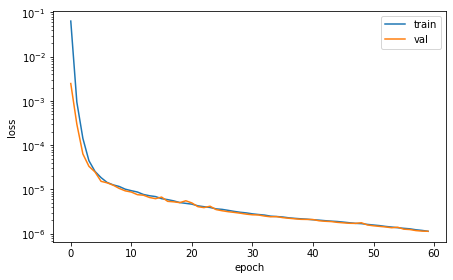

In [ ]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()

### Evaluate the model
Investigate the forecasting capabilities of the model.

In [ ]:
def predict_next_k(model, window, k=10):
    """Predict next k steps for the given model and starting sequence """
    x = window[np.newaxis, :, np.newaxis]  # initial input
    y = np.zeros(k)
    for i in range(k):
        y[i] = model.predict(x, verbose=0)
        # create the new input including the last prediction
        x = np.roll(x, -1, axis=1)  # shift all inputs 1 step to the left
        x[:, -1] = y[i]  # add latest prediction to end
    return y

In [ ]:
def plot_prediction(i0=0, k=500):
    """ Predict and plot the next k steps for an input starting at i0 """
    y0 = f[i0: i0 + window_size]  # starting window (input)
    y1 = predict_next_k(model, y0, k)  # predict next k steps

    t0 = t[i0: i0 + window_size]
    t1 = t[i0 + window_size: i0 + window_size + k]

    plt.figure(figsize=(12, 4))
    plt.plot(t, f, label='data')
    plt.plot(t0, y0, color='C1', lw=3, label='prediction')
    plt.plot(t1, y1, color='C1', ls='--')
    plt.xlim(0, 10)
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')

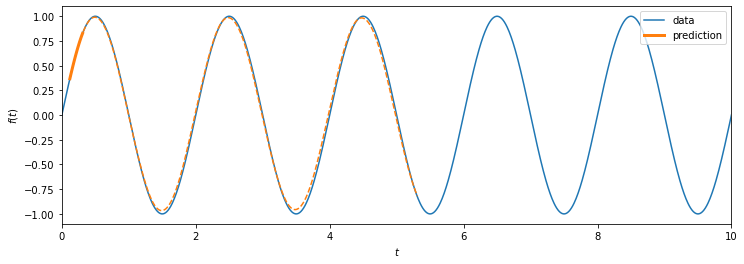

In [ ]:
plot_prediction(12)

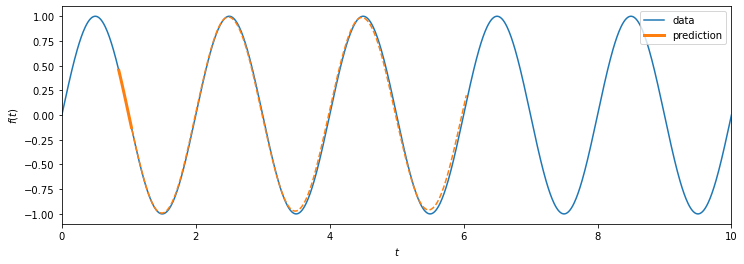

In [ ]:
plot_prediction(85)

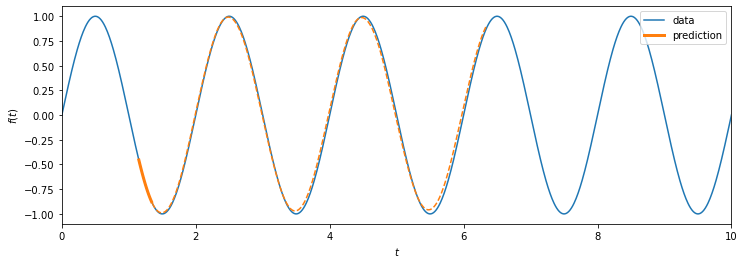

In [ ]:
plot_prediction(115)